In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

import tensorflow as tf

import keras
from keras.layers import Input, Dense, LSTM, Embedding, \
Dropout, Activation, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers.experimental.preprocessing import TextVectorization
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant


# !pip install -q -U keras-tuner
# import kerastuner as kt

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from IPython.display import display

import re

import seaborn as sns
import matplotlib.pyplot as plt
from src import load_text, get_word_index, predict_grade, separate_sentences

# !python -m spacy download en_core_web_lg
import en_core_web_lg


pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',50)

# The Data
the data consists of anonymized essays and stories written by students in grades kindergarten through high school.  We've collected these from around the web.  Let's look at some statistics below.

## Alternative Grouping
We removed samples from grades K (0) and 1 because we suspect most of them were dictated and transcribed by teachers.  They don't seem to be representative of independent writing skills.

We also combined all high school grades to 12.  Previous iterations of the model did not do well distinguishing between high school level texts.  We changed them to 12 because later we want the model to use the average of sentences to predict the grade of a longer text.  The model almost never predict 12 because an average will always bring it down.

In [13]:
df = load_text(sentences=False, grammarize=False)
df = df[df.Grade > 1]
sent_df = separate_sentences(df)

train = pd.DataFrame(columns=['Text','Grade'])
test = pd.DataFrame(columns=['Text','Grade'])

train['Text'], test['Text'], train['Grade'], test['Grade'] = \
                         train_test_split(df.Text, df.Grade, random_state=111)

sent_train = separate_sentences(train)
X_train = sent_train['Text']
y_train = sent_train['Grade']
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111)

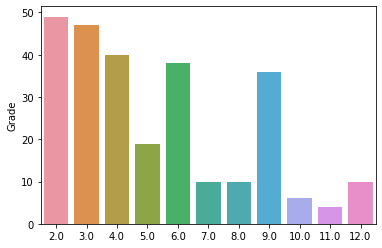

In [14]:
sns.barplot(x=df.Grade.unique(),y=df.Grade.value_counts())

You can see above that we have a large imbalance in grades represented.  It's tempting to cluster grades together, but we want a tool that predicts with some specificity.  Here's a lesson from my teaching years, however:  Most kids don't write sentences on their own in Kindergarten.  Looking over our texts for Kindergarten and first grade, these seem to be dictated and transcribed by an adult.  

In model development we also saw that high school texts are difficult to classify accurately as well.  For these reasons, we clump all high school and K-2nd grade together.  

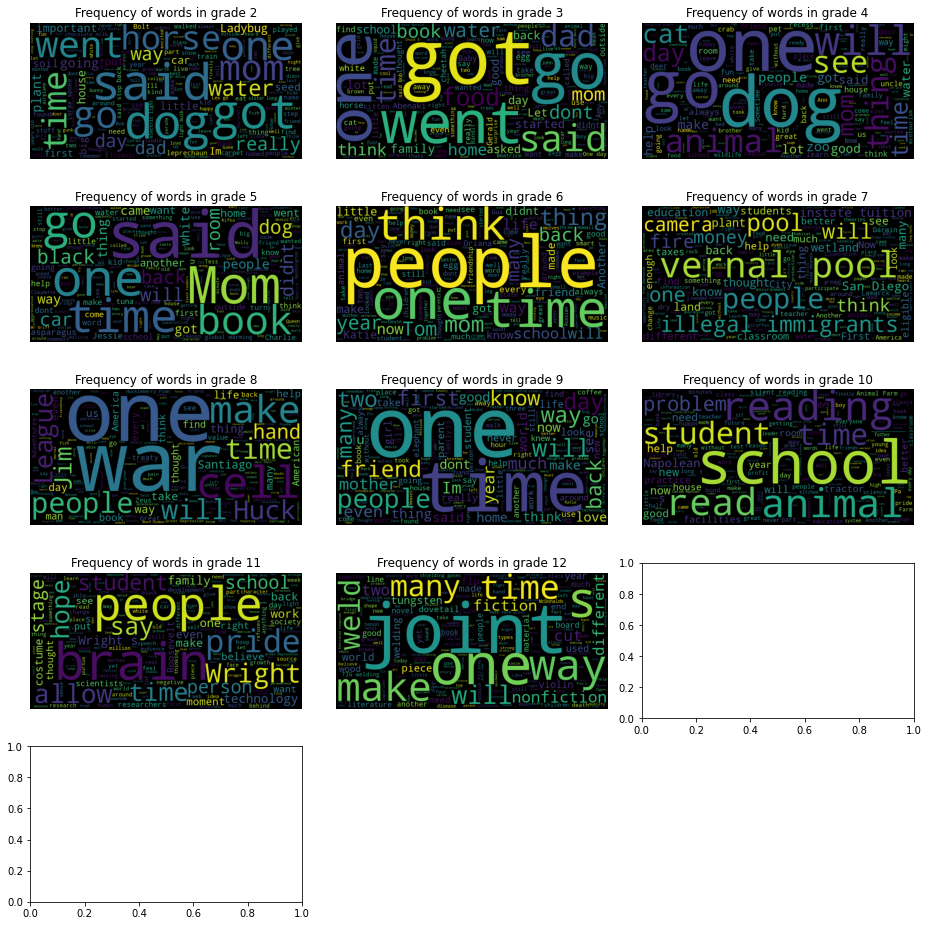

In [15]:
fig, axes = plt.subplots(5,3, figsize = (13,13))
axes=axes.ravel()
grades = sorted(df.Grade.unique())
for i, grade in enumerate(grades):
    text = ' '.join([story for story in df.loc[df.Grade == grade, 'Text']])
    axes[i].imshow(WordCloud(width=800, height=400).generate(text))
    axes[i].set_title(f'Frequency of words in grade {int(grade)}')
    axes[i].axis('off')
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
plt.tight_layout()
plt.savefig('word_clouds.png', dpi=200)
plt.show()
    

# FSM
How accurate would we be if we just predict all samples will be the median grade of the training set?  This can be our baseline model.

In [16]:
FSM = np.array([y_t.median()] * len(y_val))
FSM_MAE = np.sum(np.abs(y_val - FSM))/len(y_val)
print('Baseline MAE is: ', FSM_MAE)

Baseline MAE is:  2.5257410296411855


So, that means our model has to beat 2.6 MAE to have any predictive power.

# TF-IDF Vectorization

TF-IDF vectorization represents each word with a float representing its relative specificity to a given document.  The random forest model, however, is non-sequential.  It looks at each sentence as a collection of words.  Therefor the above power represents the opportunity to judge writing level purely by vocabulary used.

I'd like to have longer input sequences after vectorizing and padding than my longest sentence.  But, the lower you set `max_tokens` the fewer resources your model will need.

In [17]:
Vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=X_t.str.len().max())
Vectorizer.adapt(X_t.to_numpy())
X_t_tfidf = Vectorizer(X_t)
X_val_tfidf = Vectorizer(X_val)

# Linear Regression

Let's see how far we can get with the simplest of linear predictive models based on the vocabulary in the text.

In [18]:
lr_reg = LinearRegression().fit(X_t_tfidf, y_t)
yhat = lr_reg.predict(X_val_tfidf)
mae = np.sum(np.abs(y_val - yhat))/len(y_val)
print('Baseline MAE is: ', FSM_MAE)
print('MAE for Linear Regression on TF-IDF vectors = ', mae)


Baseline MAE is:  2.5257410296411855
MAE for Linear Regression on TF-IDF vectors =  2.173891615012135


The linear regression slightly beat predicting the median, but not by a lot.

# Random Forest Regressor

This is another traditional predictive model that averages the predictions of many decision tree models.  These models are not linear in their predictions like the linear regression model.  They often perform well on less linear datasets, but they take awhile to train.

In [19]:
RF_reg = RandomForestRegressor().fit(X_t_tfidf, y_t)
yhat = RF_reg.predict(X_val_tfidf)
mae = np.sum(np.abs(y_val - yhat))/len(y_val)
print('Baseline MAE is: ', FSM_MAE)
print('MAE for Random forest TF-IDF vectors = ', mae)


Baseline MAE is:  2.5257410296411855
MAE for Random forest TF-IDF vectors =  2.1283047650041413


The random forest model also did not beat the baseline by very much.


# XGBoost

In [20]:
from xgboost import XGBRegressor
XGB_reg = XGBRegressor().fit(X_t_tfidf, y_t)
yhat = XGB_reg.predict(X_val_tfidf)
mae = np.sum(np.abs(y_val - yhat))/len(y_val)
print('Baseline MAE is: ', FSM_MAE)
print('MAE for XGBoost TF-IDF vectors = ', mae)

[11:27:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Baseline MAE is:  2.5257410296411855
MAE for XGBoost TF-IDF vectors =  2.234301656221141


XGBoost did not seem to improve much.


## Shallow Model development opportunities:
My goal in this project is to explore deep learning NLP approaches, so I did not spend a lot of time tuning the traditional models.  I include them more as reference and justification for models that require greater computational resources.

Opportunities:

1. Hyperparameter tuning of traditional models

# Deep Models

I wonder if a model that explores the grammar and semantic relationships between words within the student writing samples might have greater insight into stages of writing development?  



# TextVectorization

We used TextVectorization as TF-IDF encoder above, but it can also be used as a Keras model layer.  I create a new TextVectorization object with appropriate sequence lengths for padding.  Each word will be encoded as an integer and sentences will be arrays of integers.

# Word Embedding

My first choice, in order to preserve some of the semantic relationships between the words I used word embeddings, rather than TF-IDF, to vectorize my texts.  This is a very different approach and, in fact, whereas in many other vectorization strategies each word is represented by a single number, word embeddings encode each word as a high dimensional vector array.  That means that a sentence becomes a 2D matrix.  

We don't encode the texts as such yet, but we do need to create a reference matrix to translate word encodings to their matching embedding vector.  Now Keras provides trainable embedding layers that learn along with the other layers of your model.  They contain huge numbers of weights depending on the size of your vocabulary and embedding length.

However, there are several libraries of pre-trained word embeddings that can be loaded.  I use the SpaCy NLP package to create a word embedding matrix as a 2D matrix.  The indices will be the keys and the matching row will be the embedding.  These integers match the encoding that the TextVectorization layer uses.

This matrix can then be loaded in as the weights of a Keras Embedding layer.  Remember to set `trainable=False`. The model will use the Embedding layer to cross-reference each word in the sentence.  These embeddings will suggest word relationships and will be read in order by the next layer, the Long-Short Term Memory layer.

Thanks to https://keras.io/examples/nlp/pretrained_word_embeddings/ and Kefei Mo https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633 for the below code to create the weights matrix:

In [21]:
# Establish sequence length.  Set here as the longest sentence in the training set.
longest_sentence = X_train.str.len().max()

# Instantiate and fit the vectorizing layer.  
# We can use this as a transformer, a vocabulary, and a layer in our model.
Vectorizer = TextVectorization(output_sequence_length=longest_sentence, max_tokens=2000)
Vectorizer.adapt(X_train.to_numpy())
vocab = Vectorizer.get_vocabulary()

# Load the SpaCy model as 'nlp'
nlp = en_core_web_lg.load()

#generate the embedding matrix
num_tokens = len(vocab)
embedding_dim = len(nlp('The').vector)
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocab):
    embedding_matrix[i] = nlp(word).vector

#Load the embedding matrix as the weights matrix for the embedding layer and set trainable to False
Embedding_layer=Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False)

# Hybrid Bi-directional
We are going to pull out all the guns here and use a bi-directional LSTM with that pre-trained SpaCy embedding layer.  We are going to throw that on top of a deep densely connected network with a global max pool layer between them.

The data comes in at the input layer and to the vectorizing layer which translates them into uniform length integer arrays.  Those arrays are are expanded into a 2D matrix in the Embedding layer.  The LSTM layer then reads the embeddings in the order they originally appeared in the text and makes choices about them.  This is a learned skill.  The bidirectional wrapper sends the text embedding both forward and backward through the layer and concatenates the output sequences together.  The GlobalMaxPooling1D layer reduces the dimensionality back down to pass to the densely connected layers.

The model then outputs a float which represents its guess at the grade level of the author of a text.

In [23]:

filepath = 'model-BiLSTM-MLP-hybrid'
def make_BiLSTM():
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(Vectorizer)
    model.add(Embedding_layer)
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

model = make_BiLSTM()
print(model.summary())
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True,
                             mode='min',
                             save_format='tf'
                             )
callbacks = [checkpoint]

history = model.fit(X_train,
            y_train,
            epochs=60,
            batch_size=100,
            validation_split = .2,
            verbose=1,
            callbacks=callbacks)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_3 (TextVe (None, 364)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 364, 300)          600000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 364, 200)          320800    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               25728     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)              

KeyboardInterrupt: 

# Model Evaluation
This model takes forever to train.  While having a frozen embedding layer helps reduce the number of weights to update, you'll want to train this on something with a good CUDA GPU.  It scores a 1.7 grade level average error, quite a bit better than the FSM accuracy of 2.5.  

In [ ]:
filepath = 'model-BiLSTM-MLP-hybrid'
model = keras.models.load_model(filepath)
yhat = model.predict(test.Text).ravel()
print('MAE = ', np.sum(np.abs(test.Grade-yhat))/len(test.Grade))
print('STD of errors: ', np.abs(test.Grade - yhat).std())
print('mean grade prediction = ', np.mean(yhat))
print('mean grade = ', np.mean(test.Grade))

errors = pd.DataFrame()
errors['Text'] = test.Text
errors['Grade'] = test.Grade
errors['Predicted Grade'] = yhat
errors.sample(5)

# Sentence Average Grade Approach

In order to create more data to train on we split samples into individual sentences while retaining the original grade label for each one.  New texts then will also be broken down into sentences, individual predictions are made on each sentence, and the model returns the mean average grade level prediction over all sentences. 

This approach was to combat previous bias in our models toward longer texts being higher grades, to create more data, and to reduce the size of input sequences.  Some of the texts are several pages long.  This also somewhat helped the class imbalance because the older students, which we had fewer of, also wrote texts with more sentences.  

Finally, it can take advantage of the 'Wisdom of the Crowds' effect to improve the accuracy on longer texts.

`predict_grade()` splits the input text into sentences, uses the input model to make predictions on each one, then returns the mean average of the sentences level predictions as the prediction for the entire text.

In [ ]:
# model = load_model('model-BiLSTM-MLP-hybrid')
errors = test.copy().reset_index(drop=True)
yhat = predict_grade(model, test.Text)
errors['average_prediction'] = yhat

print('MAE of average sentence predictor is: ', np.sum(np.abs(errors['Grade'] - errors['average_prediction']))/len(errors))
errors.sample(5)

The accuracy jumped from 1.8 grade levels average error to 1.4.  In other words, the longer the writing sample, the more accurate the model should be, at least up to a point.

Another note here is that while the model takes a long time to load, being almost a 1GB in size, the predictions aren't too slow.

# Conclusion
With a top accuracy of 1.4 grade levels average error, this model is probably not very useful to a teacher. There are many aspects that go into writing development and the small sample size of our data doesn't give enough.  While dividing texts by sentences raises our sample size from ~300 to ~10,000, there are still only 300 individual writers represented.  The component sentences in a document are going to be highly correlated to the writer and therefor offer less diverse information to the model than if all 10,000 were from independent sources.  

~300 is just not enough student writers to find the trends in the noise.  A dataset of 10,000 writing samples from young writers, labeled with their current grade of study, might be enough to return some very interesting insights and much more accurate predictions.  Ideally the writing samples would be selected as representing grade appropriate standards according to the CCSS.  If an accurate predictor could be created that would return the Common Core Standards aligned grade level of a writing, based on writing mechanics.

Our baseline model, simply the median of the training set predicted for every text, had an average accuracy of 2.6 grade levels on the validation set.  Traditional machine learning models, linear regression, random forest, and XGBoost improved on that a little by encoding the texts into TF-IDF vectors and fitting on them.  

We then tried vectorizing the texts using pre-trained word embedding vectors from the SpaCy large web collected word embedding dictionary.  We used a TextVectorization layer to first encode the words in the text into integers, which the model then used to look up the embeddings in the embedding layer.  This added a dimension to our data before it was passed into a bidirectional Long-Short Term Memory recurrent neural network layer.  The output sequence of that LSTM is flattened and passed through 10 layers of ever shrinking dense layers interspersed with dropout layers for regularization.

The output is a regression, not a classification.  It would be simple to make it a classification with rounding, though.  This is essentially what a sigmoid activation on the final layer would do anyway.

The model scores significantly better than both the median predictor and any of the shallow models.  While an accuracy of rough one and a half grade levels may not be good enough for use by teachers, it is proof that writing level CAN be predicted, at least to some degree.  

# Future Study
I recommend more study go into modeling writing development.  The greatest need, from what I could find, is in the collection and anonymization of labeled writing samples from K-12 students.  With a greater library of labeled samples I hypothesize that the model can achieve a precision within one grade level.

There are also many more modeling options that can be explored.  I've seen some architectures with convolutional layers.  

There are also many more opportunities for text preparation.  NLP is a complex art and tools abound.